In [1]:
import deepthought, mne, os

from deepthought.util.logging_util import configure_custom
configure_custom(debug=False)
mne.set_log_level('WARNING')
verbose = False

# sfreq = 512
sfreq = 64 # resample for speed up

# select data to be analyzed
# subjects = ['P01','P04','P06','P07','P09','P11','P12','P13','P14']
subjects = ['P07']

data_root = os.path.join(deepthought.DATA_PATH, 'OpenMIIR')

tmin = -0.201  # start of each epoch (200ms before the trigger)
tmax = 0.3  # end of each epoch (300ms after the trigger) 

Couldn't import dot_parser, loading of dot files will not be possible.


In [5]:
epoch_data = dict()

In [6]:
# extract epochs from raw data - lazy version using convenience functions
from deepthought.datasets.openmiir.preprocessing import load_and_preprocess_raw
from deepthought.datasets.openmiir.epochs import get_subject_beat_epochs

for subject in subjects:
    if subject in epoch_data: continue
    raw, trial_events = load_and_preprocess_raw(subject,                            
                            onsets='audio', interpolate_bad_channels=True, reference_mastoids=False,
                            l_freq=0.5, h_freq=30,
                            sfreq=sfreq, 
                            ica_cleaning=True,
                            verbose=verbose)

    epochs = get_subject_beat_epochs(subject, raw=raw, events=trial_events, 
                                 cue_value=0, # 0 = cue, 1 = regular
                                 tmin=tmin, tmax=tmax, verbose=verbose)

    epoch_data[subject] = epochs

Loading raw data for subject "P07" from /imaging/deepthought/datasets/OpenMIIR/eeg/mne/P07-raw.fif
Applying filter: low_cut_freq=0.5 high_cut_freq=30
Resampling 69 channels...
Excluding ICA components: [0, 2]


In [7]:
# DEPRECATED extract epochs from raw data - alternative version with single steps

from deepthought.datasets.openmiir.metadata import get_stimuli_version
from deepthought.datasets.openmiir.preprocessing.pipeline import load_raw, load_ica
from deepthought.datasets.openmiir.preprocessing.events import generate_beat_events, decode_beat_event_type
from deepthought.mneext.resample import fast_resample_mne, resample_mne_events
import numpy as np

for subject in subjects:
    if subject in epoch_data: continue
        
    # load the imported fif data, use the audio onsets
    raw = load_raw(subject, onsets='audio', interpolate_bad_channels=True, verbose=verbose)

    # select EEG channels, IMPORTANT: exclude=[] 
    eeg_picks = mne.pick_types(raw.info, meg=False, eeg=True, eog=False, stim=False, exclude=[])
    
    # apply bandpass filter, use 4 processes to speed things up
    raw.filter(0.5, 30, picks=eeg_picks, filter_length='10s',
               l_trans_bandwidth=0.1, h_trans_bandwidth=0.5, method='fft',
               n_jobs=4, verbose=True)
    
    # ICA cleaning    
    ica = load_ica(subject, description='100p_64c')
    raw = ica.apply(raw, exclude=ica.exclude, copy=False)

    # extract trial events
    trial_events = mne.find_events(raw, stim_channel='STI 014', shortest_event=0)
    
    ## event processing
    
    # read meta based on subject
    meta_version = get_stimuli_version(subject)

    # generate beat_events
    beat_events = generate_beat_events(trial_events, 
                                       include_cue_beats=True, use_audio_onset=True, 
                                       sr=raw.info['sfreq'],
                                       version=meta_version)
    # keep only the cue beat events
    cue_beat_events = list()
    for event in beat_events:
        etype = event[2]
        stimulus_id, condition, cue, beat_count = decode_beat_event_type(etype)

        if cue == 0: # this means, it is a cue beat
            cue_beat_events.append(event)
    cue_beat_events = np.asarray(cue_beat_events)
    print cue_beat_events.shape

    # compute epochs
    event_id = None # any
    detrend = 0 # remove dc
    # reject = dict(eog=250e-6) # TODO: optionally reject epochs
    cue_beat_epochs = mne.Epochs(raw, cue_beat_events, event_id,
                                  tmin, tmax, preload=True,
                                  proj=False, picks=eeg_picks, verbose=False)
    
    # optional downsamplingn (for speed-up due to fewer time steps)
    if sfreq < raw.info['sfreq']:
        o_sfreq = raw.info['sfreq']
        fast_resample_mne(raw, sfreq, res_type='sinc_fastest', preserve_events=True, verbose=False)    
        # IMPORTANT: events have to be resampled, too - otherwise misalignment      
        cue_beat_events = resample_mne_events(cue_beat_events, o_sfreq, sfreq)
    
    # create epochs structure
    cue_beat_epochs_64Hz = mne.Epochs(raw, cue_beat_events, event_id,
                                  tmin, tmax, preload=True,
                                  proj=False, picks=eeg_picks, verbose=False)
    
    if len(cue_beat_epochs_64Hz.info['bads']) > 0:
        cue_beat_epochs_64Hz.interpolate_bads()
    epoch_data[subject] = cue_beat_epochs_64Hz

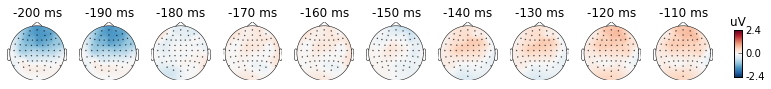

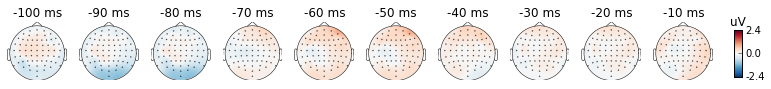

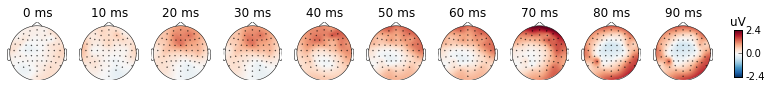

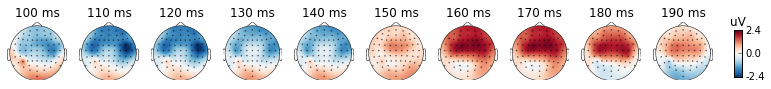

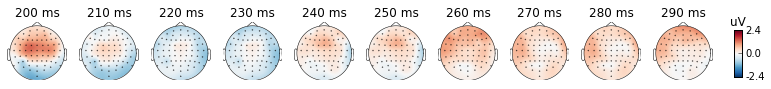

In [8]:
# simple plot function

import matplotlib.pyplot as plt
%matplotlib inline

# compute ERP
evoked = epoch_data[subjects[0]].average()

# use same scale for all time steps
scale = 1e-6
vmax = abs(evoked.data).max()/scale
vmin = -vmax

# set time instants in seconds (from -200 to 300ms in a step of 10ms)
# If times is set to None only 10 regularly spaced topographies will be shown
    
for i in range(-2,3):
    times = np.arange(i*100, (i+1)*100, 10)/1000.
    evoked.plot_topomap(times, ch_type='eeg', contours=False, vmax=vmax, vmin=-vmax, cmap='RdBu_r')


In [9]:
# JS Animation import is available at http://github.com/jakevdp/JSAnimation
# from JSAnimation.IPython_display import display_animation

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import animation
import matplotlib.gridspec as gridspec

from mne.channels import read_layout
layout = mne.channels.read_layout('biosemi.lay')

def animate_evoked_topomap(evoked, layout, title, output_filepath):
    
    scale = 1e-6
    vmax = abs(evoked.data).max()/scale
    vmin = -vmax
    data = evoked.data/scale
    print data.shape

    scale_time = 1e3
    times = evoked.times * scale_time
    
    fig = plt.figure(figsize=(12,5))
    plt.suptitle(title)
    subplot_grid = gridspec.GridSpec(1, 3)
    
    axes2 = plt.subplot(subplot_grid[0, :2])
    axes2.plot(times, data.T, color='lightgrey')
    axes2.set_xlim(times[0], times[-1])
    axes2.set_xlabel('time (ms)')
    axes2.set_ylabel('data (uV)') 
    progress = axes2.plot(times, data.T, color='k')

    axes = plt.subplot(subplot_grid[0, 2])

    def animate(i):
        t = evoked.times[i]
        tp, _ = mne.viz.plot_topomap(data[:, i], layout.pos, vmin=vmin, vmax=vmax,
                              sensors=True, res=64, names=layout.names,
                              show_names=False, cmap='RdBu_r',
                              axis=axes, contours=False)        

        axes.set_title('%01d ms' % (t * scale_time))

        for j, line in enumerate(progress):
            line.set_data(times[:i+1], data[j, :i+1].T)

        print 'plotting image', i, 'of', len(evoked.times) # just to see some progress
        return progress,
    
    def init():
        tp = animate(0)    
        for line in progress:
            line.set_data([], [])
        return progress,


    # call the animator.  blit=True means only re-draw the parts that have changed.
    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(times), interval=1) #, blit=True)

    if output_filepath is not None:
    #     writer = animation.writers['ffmpeg'](fps=30)
    #     anim.save('demo.mp4',writer=writer,dpi=dpi)
        print 'writing', output_filepath
        anim.save(output_filepath, writer='imagemagick')

    # call our new function to display the animation
#     display_animation(anim, default_mode='loop') # does not work



# TODO: A colorbar would be nice
    
# title=None
# n=1
# size=1
# nax = n + bool(colorbar)
# width = size * nax
# height = size * 1. + max(0, 0.1 * (4 - size))
# fig = plt.figure(figsize=(width, height))
# w_frame = plt.rcParams['figure.subplot.wspace'] / (2 * nax)
# top_frame = max((0.05 if title is None else 0.15), .2 / size)
# fig.subplots_adjust(left=w_frame, right=1 - w_frame, bottom=0,
#                     top=1 - top_frame)

# if colorbar:
#     cax = plt.subplot(1, 2, 2)
#     plt.colorbar(images[-1], ax=cax, cax=cax, ticks=[vmin, 0, vmax],
#                  format=format)
#     # resize the colorbar (by default the color fills the whole axes)
#     cpos = cax.get_position()
#     if size <= 1:
#         cpos.x0 = 1 - (.7 + .1 / size) / nax
#     cpos.x1 = cpos.x0 + .1 / nax
#     cpos.y0 = .1
#     cpos.y1 = .7
#     cax.set_position(cpos)
#     if unit is not None:
#         cax.set_title(unit)

In [10]:
def get_output_filepath(subject):
    return 'cue-evoked_{}.gif'.format(subject)

subject: P07, epochs: <Epochs  |  n_events : 800 (all good), tmin : -0.201 (s), tmax : 0.3 (s), baseline : (None, 0),
 '101101': 10, '101102': 10, '101103': 10, '101201': 10, '101202': 10, '101203': 10, '102101': 10, '102102': 10, '102103': 10, '102201': 10, '102202': 10, '102203': 10, '103101': 10, '103102': 10, '103103': 10, '103104': 10, '103201': 10, '103202': 10, '103203': 10, '103204': 10, '104101': 10, '104102': 10, '104103': 10, '104104': 10, '104201': 10, '104202': 10, '104203': 10, '104204': 10, '111101': 10, '111102': 10, '111103': 10, '111201': 10, '111202': 10, '111203': 10, '112101': 10, '112102': 10, '112103': 10, '112201': 10, '112202': 10, '112203': 10, '113101': 10, '113102': 10, '113103': 10, '113104': 10, '113201': 10, '113202': 10, '113203': 10, '113204': 10, '114101': 10, '114102': 10, '114103': 10, '114104': 10, '114201': 10, '114202': 10, '114203': 10, '114204': 10, '121101': 10, '121102': 10, '121103': 10, '121201': 10, '121202': 10, '121203': 10, '122101': 10,

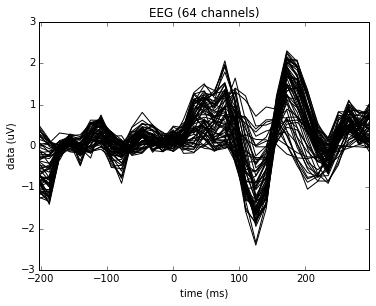

(64, 33)


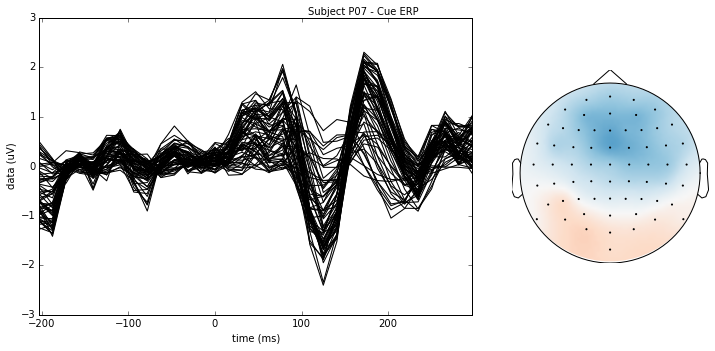

plotting image 0 of 33
writing cue-evoked_P07.gif


plotting image 0 of 33


plotting image 1 of 33


plotting image 2 of 33


plotting image 3 of 33


plotting image 4 of 33


plotting image 5 of 33


plotting image 6 of 33


plotting image 7 of 33


plotting image 8 of 33


plotting image 9 of 33


plotting image 10 of 33


plotting image 11 of 33


plotting image 12 of 33


plotting image 13 of 33


plotting image 14 of 33


plotting image 15 of 33


plotting image 16 of 33


plotting image 17 of 33


plotting image 18 of 33


plotting image 19 of 33


plotting image 20 of 33


plotting image 21 of 33


plotting image 22 of 33


plotting image 23 of 33


plotting image 24 of 33


plotting image 25 of 33


plotting image 26 of 33


plotting image 27 of 33


plotting image 28 of 33


plotting image 29 of 33


plotting image 30 of 33


plotting image 31 of 33


plotting image 32 of 33


In [11]:
from deepthought.datasets.openmiir.preprocessing.pipeline import interpolate_bad_channels

for subject in subjects:    
    epochs = epoch_data[subject]
    print 'subject: {}, epochs: {}'.format(subject, epochs)

    evoked = epochs.average()
    evoked.plot()
    
    animate_evoked_topomap(evoked, layout, 
                           title='Subject {} - Cue ERP'.format(subject), 
                           output_filepath=get_output_filepath(subject))
#     break

In [12]:
# load the images
from IPython.display import HTML
from IPython.display import display

for subject in subjects:    
    html = HTML('<img src="{}">'.format(get_output_filepath(subject)))
    display(html)

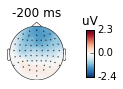

[-0.203125 -0.1875   -0.171875 -0.15625  -0.140625 -0.125    -0.109375
 -0.09375  -0.078125 -0.0625   -0.046875 -0.03125  -0.015625  0.        0.015625
  0.03125   0.046875  0.0625    0.078125  0.09375   0.109375  0.125
  0.140625  0.15625   0.171875  0.1875    0.203125  0.21875   0.234375
  0.25      0.265625  0.28125   0.296875]


In [13]:
vmin = evoked.data.min()
vmax = evoked.data.max()
evoked.plot_topomap(-0.2, ch_type='eeg', vmin=vmin/1e-6, vmax=vmax/1e-6, contours=None);
print evoked.times